This notebook demonstrates the simple usage of pretrained foundation model backbones on an image segmentation task. It includes:
- Load a semantic segmentation dataset
- Load a pretrained foundation model as encoder
- Build a segmentation task head/decoder
- Finetune the model while freezing the encoder
- Test the trained model for quantitative performance metrics
- Inference on some samples

Note: It is very similar for dense regression tasks. We just need to adjust:
- the output layer of the decoder
- the loss function to L2 or L1 loss
- the evaluation metrics to RMSE, R2, etc.

In [ ]:
# install dependencies
!pip install -q torchgeo # for dataset and some supported models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 605.3/605.3 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 74.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 859.3/859.3 kB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 824.2/824.2 kB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.6/507.6 kB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.6/165.6 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# import basic libraries
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime

# check device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Load dataset

We use the CopernicusBench-DFC2020-S1 dataset for example. This dataset is a regression dataset based on Sentinel-1 GRD images (2 bands, 10m resolution) and human-annotated LULC maps (10m resolution).

In [ ]:
from torchgeo.datasets import CopernicusBenchDFC2020S1
import kornia as K

mean = [-12.548, -20.192]
std = [5.257, 5.912]

transforms_train = K.augmentation.AugmentationSequential(
  K.augmentation.RandomResizedCrop(size=(224,224), scale=(0.8,1.0)),
  K.augmentation.RandomHorizontalFlip(p=0.5),
  K.augmentation.Normalize(mean=mean, std=std),
  data_keys=None,
  keepdim=True,
)

transforms_test = K.augmentation.AugmentationSequential(
  K.augmentation.Resize(size=(224,224), align_corners=True),
  K.augmentation.Normalize(mean=mean, std=std),
  data_keys=None,
  keepdim=True,
)

# Load the dataset as a Pytorch Dataset
dataset_train = CopernicusBenchDFC2020S1(root='data', split='train', bands=None, transforms=transforms_train, download=True, checksum=False)
dataset_val = CopernicusBenchDFC2020S1(root='data', split='val', bands=None, transforms=transforms_test, download=True, checksum=False)
dataset_test = CopernicusBenchDFC2020S1(root='data', split='test', bands=None, transforms=transforms_test, download=True, checksum=False)

100%|██████████| 8.76G/8.76G [03:22<00:00, 43.3MB/s]


dict_keys(['image', 'mask'])
torch.Size([2, 224, 224]) torch.Size([224, 224])


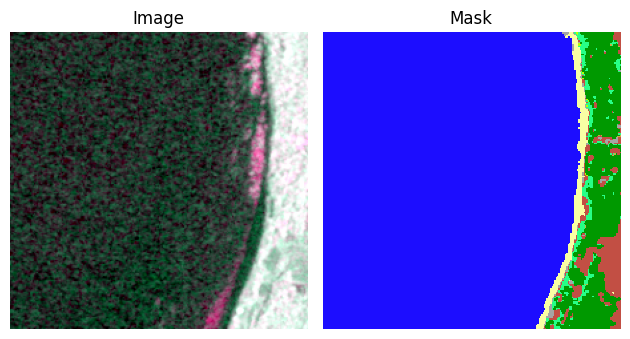

In [ ]:
# check and visualize some data
sample = dataset_train[0]
print(sample.keys())
print(sample['image'].shape, sample['mask'].shape)

dataset_train.plot(sample).show()

In [ ]:
# create dataloader
dataloader_train = DataLoader(dataset_train, batch_size=16, num_workers=2, drop_last=True)
dataloader_val = DataLoader(dataset_val, batch_size=16, num_workers=2, drop_last=False)
dataloader_test = DataLoader(dataset_test, batch_size=16, num_workers=2, drop_last=False)

## Load pretrained foundation model
In this demo, we choose [DOFA](https://github.com/zhu-xlab/DOFA) as the foundation model used here. We simply load the model from TorchGeo. Check `track1_demo1_classification.ipynb` for examples loading from source code.

In [ ]:
from torchgeo.models import dofa_base_patch16_224,DOFABase16_Weights

dofa_model = dofa_base_patch16_224(weights=DOFABase16_Weights.DOFA_MAE)

In [ ]:
print(dofa_model)

DOFA(
  (fc_norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (patch_embed): DOFAEmbedding(
    (weight_generator): TransformerWeightGenerator(
      (transformer_encoder): TransformerEncoder(
        (layers): ModuleList(
          (0): TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
            )
            (linear1): Linear(in_features=128, out_features=2048, bias=True)
            (dropout): Dropout(p=False, inplace=False)
            (linear2): Linear(in_features=2048, out_features=128, bias=True)
            (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (dropout1): Dropout(p=False, inplace=False)
            (dropout2): Dropout(p=False, inplace=False)
          )
        )
      )
      (fc_weight): Linear(in_features=128, out_features=1966

In torchgeo, DOFA `forward_features()` outputs the cls token with shape [B,D], removing patch tokens. For segmentation task, we would need those patch tokens. Therefore, we can build a wrapper on top of torchgeo's DOFA.

In [ ]:
class DOFASegWrapper(torch.nn.Module):
    def __init__(self, encoder: torch.nn.Module):
        super().__init__()
        self.encoder = encoder

    def forward(self, x: torch.Tensor, wavelengths: list[float]):
        # core forward pass the same as original
        # 1) patch embedding
        waves = torch.tensor(wavelengths, device=x.device).float()
        x, _ = self.encoder.patch_embed(x, waves)        # [B, N, D]
        # 2) positional encoding
        x = x + self.encoder.pos_embed[:, 1:, :]         # [B, N, D]
        cls_token = self.encoder.cls_token + self.encoder.pos_embed[:, :1, :]
        x = torch.cat((cls_token.expand(x.shape[0], -1, -1), x), dim=1)  # [B, 1+N, D]
        # 3) Transformer blocks
        for block in self.encoder.blocks:
            x = block(x)
        # x = self.encoder.norm(x) # [B, 1+N, D]

        # modify output
        # cls = x[:, 0] # [B, D]
        tokens = x[:, 1:] # [B, N, D]

        B, N, C = tokens.shape
        hw_shape = int(N ** 0.5)
        tokens = (
            tokens.reshape(B, hw_shape, hw_shape, C)
            .permute(0, 3, 1, 2)
            .contiguous()
        )

        return tokens

encoder = DOFASegWrapper(dofa_model)

## Build task model
Pretrained foundation models usually serve only as the encoder. For a segmentation downstream task we need a task head/decoder to output segmentation maps. During training, we can either fine tune all parameters both in encoder and decoder, or fine tune part of the parameters (e.g. only the decoder).


In [ ]:
# build segmentation decoder
import torch.nn as nn
import torch.nn.functional as F

class SimpleFCNDecoder(nn.Module):
    def __init__(self, in_channels, num_classes, out_size):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(in_channels // 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // 2, in_channels // 4, kernel_size=3, padding=1),
            nn.BatchNorm2d(in_channels // 4),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // 4, num_classes, kernel_size=1)
        )
        self.out_size = out_size

    def forward(self, x):
        x = self.decoder(x)  # [B, num_classes, H/p, W/p]
        x = F.interpolate(x, size=self.out_size, mode='bilinear', align_corners=False)
        return x  # [B, num_classes, H, W]

decoder = SimpleFCNDecoder(in_channels=768, num_classes=11, out_size=(224,224))

print(decoder)

SimpleFCNDecoder(
  (decoder): Sequential(
    (0): Conv2d(768, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(384, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(192, 11, kernel_size=(1, 1), stride=(1, 1))
  )
)


In [ ]:
# freeze the encoder, such that only the task head is trained
for param in encoder.parameters():
    param.requires_grad = False

total_params = sum(p.numel() for p in encoder.parameters()) + sum(p.numel() for p in decoder.parameters())
trainable_params = sum(p.numel() for p in decoder.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Total parameters: 114,668,344
Trainable parameters: 3,321,611


## Loss and optimizer

In [ ]:
# model to GPU
encoder.to(device)
decoder.to(device)

# Define loss and optimizer
criterion = torch.nn.CrossEntropyLoss(ignore_index=0) # ignore background
optimizer = torch.optim.AdamW(decoder.parameters(), lr=1e-4)


## Training

In [ ]:
# DOFA requires channel wavelengths to dynamically generate patch embedding weights
wvs = [5.405, 5.405]

In [ ]:
num_epochs = 5
decoder.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    for batch in tqdm(dataloader_train, desc=f"Epoch {epoch+1}"):
        # image and ground truth
        x = batch['image'].to(device)        # [B, 2, 224, 224]
        y = batch['mask'].to(device)        # [B, 224, 224]

        with torch.no_grad():
            feats = encoder(x,wvs) # [B, C, h, w]
        preds = decoder(feats) # [B, 11, 224, 224], 0 is background to be ignored

        loss = criterion(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1} - Loss: {epoch_loss / len(dataloader_train):.4f}")

Epoch 1:   0%|          | 0/197 [00:00<?, ?it/s]/tmp/ipython-input-2739610572.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  waves = torch.tensor(wavelengths, device=x.device).float()
Epoch 1:   2%|▏         | 3/197 [00:36<39:30, 12.22s/it]


KeyboardInterrupt: 

## Testing

In [ ]:
from torchmetrics.functional import jaccard_index

decoder.eval()
miou = 0
for batch in tqdm(dataloader_test):
    # image and ground truth
    x = batch['image'].to(device)        # [B, 2, 224, 224]
    y = batch['mask'].to(device)        # [B, 224, 224]

    with torch.no_grad():
        feats = encoder(x,wvs) # [B, 768, 16, 16]
    preds = decoder(feats) # [B, 11, 224, 224]
    preds = torch.argmax(preds,dim=1)

    miou += jaccard_index(preds.detach(), y, task="multiclass", num_classes=11, ignore_index=0).cpu().numpy()

print('\n test miou:', miou/len(dataloader_test))

  0%|          | 0/62 [00:00<?, ?it/s]/tmp/ipython-input-2739610572.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  waves = torch.tensor(wavelengths, device=x.device).float()
  2%|▏         | 1/62 [00:15<15:57, 15.69s/it]


KeyboardInterrupt: 

## Inference

/tmp/ipython-input-2739610572.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  waves = torch.tensor(wavelengths, device=x.device).float()


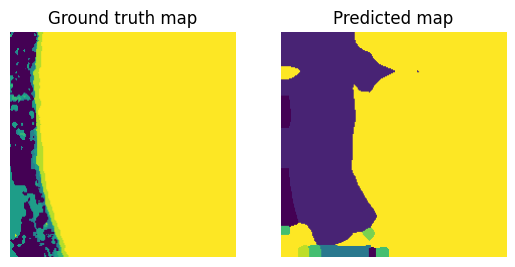

In [ ]:
decoder.eval()
sample = dataset_train[0]
x = sample['image'].unsqueeze(0).to(device)

with torch.no_grad():
    feats = encoder(x,wvs)
    pred = decoder(feats).detach()
    pred = torch.argmax(pred,dim=1).cpu().squeeze(0).numpy()

# Visualization
plt.subplot(1,2,1)
plt.imshow(sample['mask'])
plt.title("Ground truth map")
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(pred, cmap='viridis')
plt.title("Predicted map")
#plt.colorbar()
plt.axis('off')
plt.show()
